In [128]:
import keras
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU, Dropout, Embedding, Concatenate
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

In [129]:
from keras.datasets import mnist, cifar10

In [130]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [131]:
(Xtrain, Ytrain), (Xtest, Ytest) = mnist.load_data()

In [132]:
Xtrain.shape

(60000, 28, 28)

In [133]:
Xtrain

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

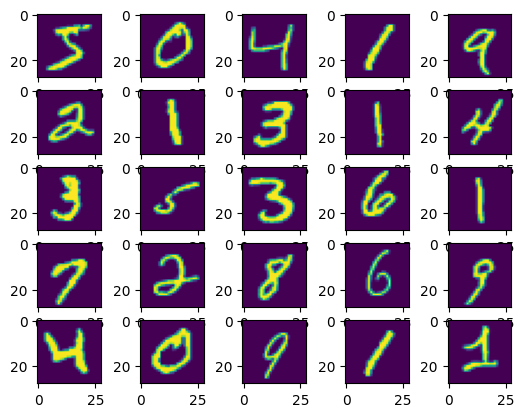

In [134]:
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(Xtrain[i])
plt.show()

In [135]:
input_shape = (28, 28)
batch_size = 10
epochs = 100
batch_per_epoch = int(Xtrain.shape[0]/batch_size)
half_size = batch_size/2
latent_dim = (100, )
latent_size = 100
nodes = 128*7*7
label_dim = (1,)

In [136]:
def build_disc(input_shape = (28, 28, 1), num_classes = 10):

  label = Input(shape = (1,))
  la = Embedding(num_classes, 7*7)(label)
  la = Dense(14*14)(la)
  la = Dense(28*28)(la)
  la = Reshape((28, 28, 1))(la)
  img = Input(shape = input_shape)
  merge = Concatenate()([img, la])
  model = Conv2D(128, (3, 3), strides = (2, 2))(merge)
  model = LeakyReLU(alpha = 0.2)(model)
  model = Conv2D(256, (3, 3), strides = (2, 2))(model)
  model = LeakyReLU(alpha = 0.2)(model)
  model = Flatten()(model)
  model = Dropout(0.3)(model)
  output = Dense(1, activation = 'sigmoid')(model)

  model = Model([img, label], output)

  model.compile(loss = 'binary_crossentropy', optimizer = Adam(0.0002, 0.5), metrics = ['accuracy'])

  return model



In [137]:
def build_gen(latent_dim = (100,), num_classes = 10):

  label = Input(shape = (1,))
  la = Embedding(num_classes, 49)(label)
  la = Dense(49)(la)
  la = Reshape((7, 7, 1))(la)
  latent = Input(shape = latent_dim)
  img = Dense(128*7*7)(latent)
  img = Reshape((7, 7, 128))(img)
  merge = Concatenate()([img, la])
  model = Conv2DTranspose(128, (3, 3), strides = (2, 2))(merge)
  model = LeakyReLU(alpha = 0.2)(model)
  model = Conv2DTranspose(128, (3, 3), strides = (2,2))(model)
  model = LeakyReLU(alpha = 0.2)(model)
  output = Conv2D(1, (4, 4), activation = 'tanh')(model)

  model = Model([latent, label], output)

  return model

In [138]:
def GAN(discriminator, generator):

  discriminator.trainable = False
  latent, label = generator.input
  gen_output = generator.output
  gan_output = discriminator([gen_output, label])
  model = Model([latent, label], gan_output)

  model.compile(loss = 'binary_crossentropy', optimizer = Adam(0.0002, 0.5), metrics = ['accuracy'])

  return model

In [139]:
GAN(build_disc(), build_gen()).summary()

Model: "model_32"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_47 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_48 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 embedding_23 (Embedding)       (None, 1, 49)        490         ['input_47[0][0]']               
                                                                                                  
 dense_59 (Dense)               (None, 6272)         633472      ['input_48[0][0]']               
                                                                                           

In [140]:
Xtrain = (Xtrain.astype(np.float32) - 127.5)/127.5

In [141]:
def real_data(num):
  idx = np.random.randint(0, Xtrain.shape[0], num)
  X = Xtrain[idx]
  label = Ytrain[idx]
  y = np.ones((num, 1))
  return [X, label], y

In [142]:
def fake_data(generator, num, latent_size):
  idx = np.random.normal(0, 1, (num, latent_size))
  label = np.random.randint(0, 10, num)
  X = generator.predict([idx, label])
  y = np.zeros((num, 1))
  return [X, label], y

In [143]:
X, y =real_data(5)
X

[array([[[-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         ...,
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.]],
 
        [[-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         ...,
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.]],
 
        [[-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         ...,
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.]],
 
        [[-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ...,

In [144]:
def train(generator, discriminator, GAN, epochs, batch_size = 128, latent_size = 100):
  batch_per_epoch = int(Xtrain.shape[0]/batch_size)
  half_size = int(batch_size/2)
  for epoch in range(epochs):
    for batch in range(batch_per_epoch):

      X_real, y_real = real_data(half_size)
      X_fake, y_fake = fake_data(generator, half_size, latent_size)

      dloss_real = discriminator.train_on_batch(X_real, y_real)
      dloss_fake = discriminator.train_on_batch(X_fake, y_fake)
      dloss = 0.5*np.add(dloss_real, dloss_fake)


      noise = np.random.normal(0, 1, (batch_size, latent_size))
      label = np.random.randint(0, 10, batch_size)
      valid = np.ones((batch_size, 1))

      gloss = GAN.train_on_batch([noise, label], valid)

    print(f"Epoch: {epoch} Disc loss: {dloss} Gen loss: {gloss}")

In [ ]:
discriminator = build_disc()
generator = build_gen()
GAN = GAN(discriminator, generator)
train(generator, discriminator, GAN, epochs = 1, batch_size = 2)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - ETA: 0s

In [ ]:
test = generator.predict([np.random.normal(0, 1, (1, 100)), np.array([3])])
test = test*127.5
test = test + 127.5
from google.colab.patches import cv2_imshow
cv2_imshow(test[0])

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(test[0])

In [ ]:
plt.imshow(test[0])

In [ ]:
[np.random.normal(0, 1, (1, 100)), np.random.randint(0, 10, 1)]

In [ ]:
a = [[0, 1], [1, 0.5]]
plt.imshow(a,  vmin=0, vmax=1)